# **UB** : Save and Restore Crystal Orientation

see: https://github.com/bluesky/hklpy/issues/50

**Objectives**

1. Save the information defining the crystal orientation into the descriptor
1. Restore crystal orientation from a given Bluesky run
1. List runs that have orientation that can be restored

In [1]:
import gi
gi.require_version('Hkl', '5.0')

from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import bluesky.preprocessors as bpp
import databroker
import hkl
from hkl.calc import A_KEV
from hkl.geometries import *
import numpy as np
import pyRestTable
from ophyd import Component, Device, EpicsSignal, Signal
from ophyd.signal import AttributeSignal
from ophyd.sim import *

bec = BestEffortCallback()
cat = databroker.temp().v2

RE = RunEngine({})
RE.subscribe(bec)
RE.subscribe(cat.v1.insert)
RE.md["notebook"] = "UB_save_restore"
RE.md["objective"] = "Demonstrate UB matrix save & restore"

-------------

In [2]:
def show_component_kinds(device):
    tbl = pyRestTable.Table()
    tbl.labels = "component kind value".split()
    for attr in device.component_names:
        obj = getattr(device, attr)
        tbl.addRow((attr, obj.kind, obj.get()))
    print(tbl)


def get_orientation_diffractometer(dfrct, run):
    run_conf = run.primary.config
    findings = []
    for det_name in run_conf:
        conf = run_conf[det_name].read()
        if f"{det_name}__orientation_data" in conf:
            got = conf[det_name+"_geometry_name"].to_dict()["data"][0]
            want = dfrct.geometry_name.get()
            # print(f'{got = }  {want = }')
            if want == got:
                # TODO: compare reals and pseudos?  that's a user option
                findings.append(det_name)
    return findings


def find_orientations(dfrct):
    tbl = pyRestTable.Table()
    tbl.labels = "scan_id command name_match? orientation_det".split()
    for run in cat.values():
        diffractometer_name = dfrct.name in run.primary.config
        scan_id = run.metadata["start"]["scan_id"]
        cmd = run.metadata["start"]["plan_name"]
        dname = get_orientation_diffractometer(dfrct, run)
        
        tbl.addRow((scan_id, cmd, diffractometer_name, dname))
    print(tbl)

-------------

In [3]:
print(f"{len(cat) = }")

len(cat) = 0


In [4]:
noisy_det.read()

OrderedDict([('noisy_det',
              {'value': 1.0831708531398894, 'timestamp': 1619303670.009278})])

In [5]:
RE(bp.count([noisy_det]))



Transient Scan ID: 1     Time: 2021-04-24 17:34:30
Persistent Unique Scan ID: '45e9c0bb-cca3-4a12-81ce-4bbc8ff36497'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |  noisy_det |
+-----------+------------+------------+
|         1 | 17:34:30.1 |      1.093 |
+-----------+------------+------------+
generator count ['45e9c0bb'] (scan num: 1)





('45e9c0bb-cca3-4a12-81ce-4bbc8ff36497',)

In [6]:
print(f"{len(cat) = }")

len(cat) = 1


-------------

In [7]:
class Fourc(SimulatedE4CV):
    pass

fourc = Fourc("", name="fourc")
a0 = 5.4310196
fourc.calc.new_sample("silicon", (a0, a0, a0, 90, 90, 90))
fourc.energy.put(A_KEV / 1.54)
r1 = fourc.calc.sample.add_reflection(4, 0, 0, (-145.451, 0, 0, 69.0966))
r2 = fourc.calc.sample.add_reflection(0, 4, 0, (-145.451, 0, 90, 69.0966))
fourc.calc.sample.compute_UB(r1, r2)
fourc.pa()

orange = Fourc("", name="orange")
orange.pa()

===================== ===========================================================================
term                  value                                                                      
===================== ===========================================================================
diffractometer        fourc                                                                      
geometry              E4CV                                                                       
class                 Fourc                                                                      
energy (keV)          8.05092                                                                    
wavelength (angstrom) 1.54000                                                                    
calc engine           hkl                                                                        
mode                  bissector                                                                  
positions           

In [8]:
class Kappa(SimulatedK4CV):
    pass

kappa = Kappa("", name="kappa")
a0 = 5.4310196
kappa.calc.new_sample("silicon", (a0, a0, a0, 90, 90, 90))
kappa.energy.put(A_KEV / 1.54)
# r1 = kappa.calc.sample.add_reflection(4, 0, 0, (...))
# r2 = kappa.calc.sample.add_reflection(0, 4, 0, (...))
# sixc.calc.sample.compute_UB(r1, r2)
kappa.pa()

===================== ====================================================================
term                  value                                                               
===================== ====================================================================
diffractometer        kappa                                                               
geometry              K4CV                                                                
class                 Kappa                                                               
energy (keV)          8.05092                                                             
wavelength (angstrom) 1.54000                                                             
calc engine           hkl                                                                 
mode                  bissector                                                           
positions             ====== =======                                                      

In [9]:
class Sixc(SimulatedE6C):
    pass

sixc = Sixc("", name="sixc")
a0 = 5.4310196
sixc.calc.new_sample("silicon", (a0, a0, a0, 90, 90, 90))
sixc.energy.put(A_KEV / 1.54)
# r1 = sixc.calc.sample.add_reflection(4, 0, 0, (...))
# r2 = sixc.calc.sample.add_reflection(0, 4, 0, (...))
# sixc.calc.sample.compute_UB(r1, r2)
sixc.pa()

===================== ====================================================================
term                  value                                                               
===================== ====================================================================
diffractometer        sixc                                                                
geometry              E6C                                                                 
class                 Sixc                                                                
energy (keV)          8.05092                                                             
wavelength (angstrom) 1.54000                                                             
calc engine           hkl                                                                 
mode                  bissector_vertical                                                  
positions             ===== =======                                                       

In [10]:
def scan_all():
    yield from bp.count([noisy_det])
    yield from bp.count([noisy_det, fourc])
    yield from bp.count([noisy_det, fourc, orange, kappa, sixc])
    yield from bp.scan([noisy_det], fourc.h, 0.9, 1.1, 2)
    yield from bp.scan([noisy_det, fourc], fourc.h, 0.9, 1.1, 2)
    yield from bp.scan([noisy_det], kappa.h, 0.9, 1.1, 2)
    yield from bp.scan([noisy_det, kappa], kappa.h, 0.9, 1.1, 2)
    yield from bp.scan([noisy_det], sixc.h, 0.9, 1.1, 2)
    yield from bp.scan([noisy_det, sixc], sixc.h, 0.9, 1.1, 2)



Transient Scan ID: 2     Time: 2021-04-24 17:34:30
Persistent Unique Scan ID: '0bd89f63-9272-4722-b425-6a43280bd184'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |  noisy_det |
+-----------+------------+------------+
|         1 | 17:34:30.3 |      1.018 |
+-----------+------------+------------+
generator count ['0bd89f63'] (scan num: 2)





Transient Scan ID: 3     Time: 2021-04-24 17:34:30
Persistent Unique Scan ID: 'ce8a6cd8-e987-4e18-8904-1a35f1b5ae5a'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |  noisy_det |    fourc_h |    fourc_k |    fourc_l |
+-----------+------------+------------+------------+------------+------------+
|         1 | 17:34:30.5 |      0.922 |      0.000 |      0.000 |      0.000 |
+-----------+------------+------------+------------+------------+------------+
generator count ['ce8a6cd8'] (scan num: 3)





Transient Scan ID: 4     Time

('0bd89f63-9272-4722-b425-6a43280bd184',
 'ce8a6cd8-e987-4e18-8904-1a35f1b5ae5a',
 '1e84243d-7474-4643-9150-28c0345ab308',
 '33f2dd9d-5d59-48c7-9587-611ae3f6d7a1',
 '949c40ff-a9ac-4b52-9654-c719b7e6ac78',
 'd0dec38c-a350-4ab2-90b9-a4c2932a6a68',
 '5c384f6d-68ac-4414-9234-47ccf3804ddf',
 '42487634-7c4c-4513-83b6-85efe9ec180d',
 '3a60477c-aee8-4bab-91e7-fc92db37103b')

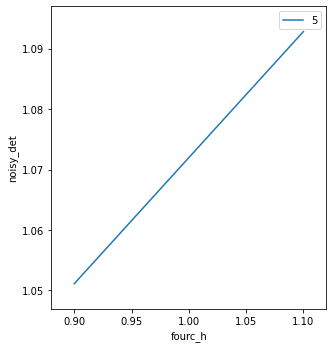

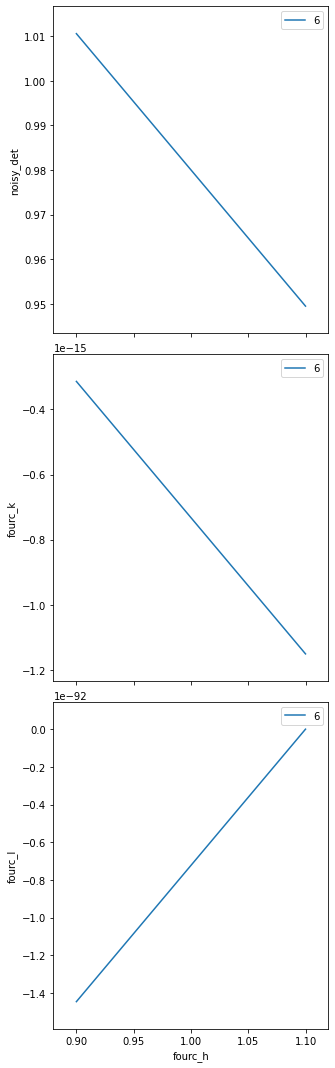

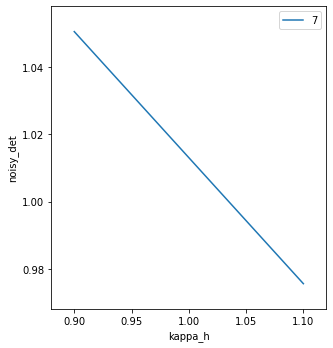

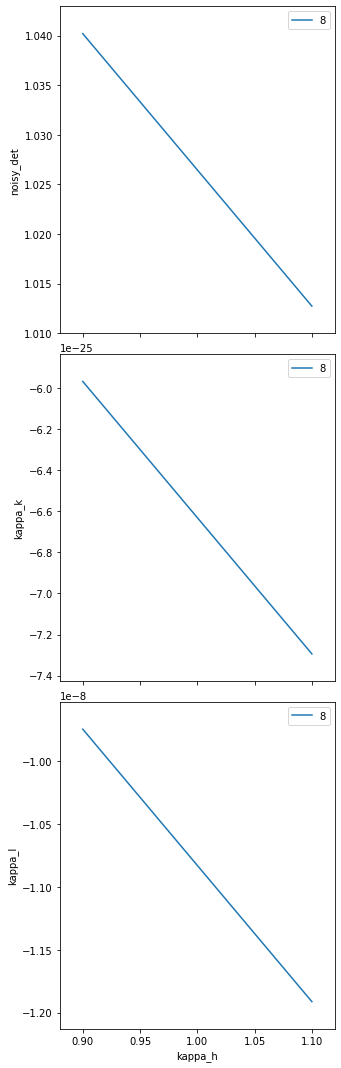

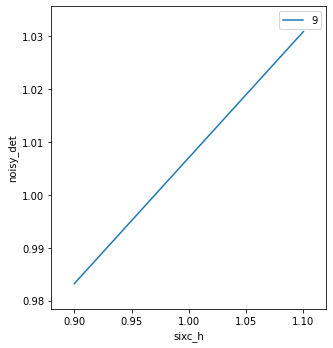

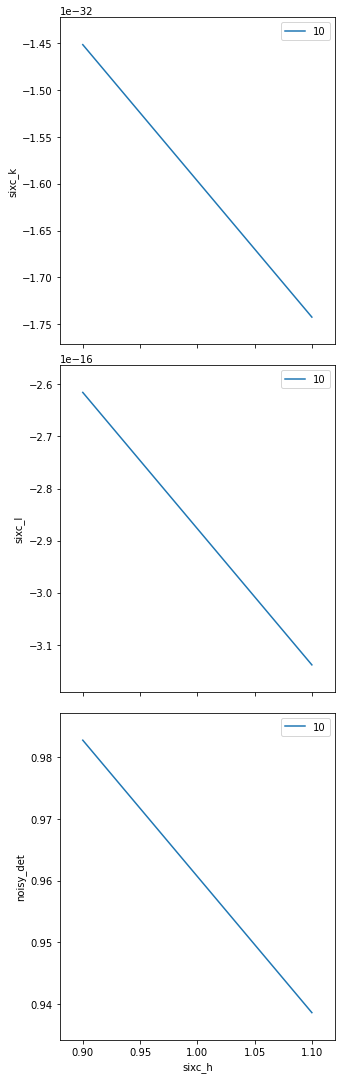

In [11]:
RE(scan_all())

In [12]:
find_orientations(fourc)

======= ======= =========== ===============
scan_id command name_match? orientation_det
======= ======= =========== ===============
1       count   False       []             
2       count   False       []             
3       count   True        []             
4       count   True        []             
5       scan    False       []             
6       scan    True        []             
7       scan    False       []             
8       scan    False       []             
9       scan    False       []             
10      scan    False       []             
======= ======= =========== ===============



------------

TODO: show series of scans with different orientation reflections and different **UB**